# Predicting 4th Semester Performance (CP)

## First three modules' performances to predict fourth semester success

In [1]:
import pandas as pd
import numpy as np

from rapp import data

In [2]:
data.connect("data/rapp.db")

sql = "sql/cs_first_three_module_fourth_term_cp.sql"
df = data.query_sql_file(sql, data.db_conn)

In [3]:
df.head()

,Geburtsjahr,Geschlecht,Deutsch,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AlgoBestanden,AlgoVersuche,AlgoNote,AnaBestanden,AnaVersuche,FourthTermCP
0,1972,männlich,1,1,1,0,0,5.0,0,0,5.0,0,0,120.0
1,1987,weiblich,1,1,1,1,1,3.7,1,1,3.0,1,1,180.0
2,1985,männlich,1,0,0,1,1,1.7,0,0,5.0,0,0,70.0
3,1988,männlich,1,1,2,1,1,3.3,0,0,5.0,0,0,70.0
4,1989,weiblich,1,1,1,0,0,5.0,1,1,1.0,1,1,180.0


Let us change the task to a binary classification problem. Assuming 30 ECTP per term, we end up with 120 CP after the fourth semester. Giving some leeway, we allow for 20 CP to be missing (two modules).

In [4]:
df_classification = df.copy(deep=True)
df_classification["FourthTermCP"] = 1*(df_classification["FourthTermCP"] >= 100)

In [5]:
df_classification.head()

,Geburtsjahr,Geschlecht,Deutsch,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AlgoBestanden,AlgoVersuche,AlgoNote,AnaBestanden,AnaVersuche,FourthTermCP
0,1972,männlich,1,1,1,0,0,5.0,0,0,5.0,0,0,1
1,1987,weiblich,1,1,1,1,1,3.7,1,1,3.0,1,1,1
2,1985,männlich,1,0,0,1,1,1.7,0,0,5.0,0,0,0
3,1988,männlich,1,1,2,1,1,3.3,0,0,5.0,0,0,0
4,1989,weiblich,1,1,1,0,0,5.0,1,1,1.0,1,1,1


We also drop Algo for now, as it does not align well with our historical data.

In [6]:
df_classification = df_classification.drop(["AlgoVersuche", "AlgoNote", "AlgoBestanden"], axis=1)
df_classification.head()

,Geburtsjahr,Geschlecht,Deutsch,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AnaBestanden,AnaVersuche,FourthTermCP
0,1972,männlich,1,1,1,0,0,5.0,0,0,1
1,1987,weiblich,1,1,1,1,1,3.7,1,1,1
2,1985,männlich,1,0,0,1,1,1.7,0,0,0
3,1988,männlich,1,1,2,1,1,3.3,0,0,0
4,1989,weiblich,1,1,1,0,0,5.0,1,1,1


We need to one-hot encode the gender.

In [7]:
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)

In [8]:
df_classification.head()

,Deutsch,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AnaBestanden,AnaVersuche,FourthTermCP,Männlich,Weiblich,Divers
0,1,1,1,0,0,5.0,0,0,1,1,0,0
1,1,1,1,1,1,3.7,1,1,1,0,1,0
2,1,0,0,1,1,1.7,0,0,0,1,0,0
3,1,1,2,1,1,3.3,0,0,0,1,0,0
4,1,1,1,0,0,5.0,1,1,1,0,1,0


### Prepare train and test set

In [9]:
X = df_classification.drop(["FourthTermCP"], axis=1)
y = df_classification["FourthTermCP"]

feature_names = X.columns

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

### Train classifier

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [12]:
clf = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)

In [13]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

In [43]:
def eval_model(clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    y_pred = clf.predict(X_train)
    bacc = balanced_accuracy_score(y_train, y_pred)
    area = roc_auc_score(y_train, y_pred)
    conf = confusion_matrix(y_train, y_pred)
    print("# Trainset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)

    y_pred = clf.predict(X_test)
    bacc = balanced_accuracy_score(y_test, y_pred)
    area = roc_auc_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    print("# Testset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)

In [15]:
eval_model(clf)

# Trainset
Balanced accuracy: 0.7963675213675214
Area under curve: 0.7963675213675214
Confusion Matrix (tn, fp, fn, tp):
[[742 194]
 [ 53 212]]
# Testset
Balanced accuracy: 0.7820265780730897
Area under curve: 0.7820265780730897
Confusion Matrix (tn, fp, fn, tp):
[[236  65]
 [ 22  78]]


### Display rules learned

In [16]:
%matplotlib inline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [60, 20]

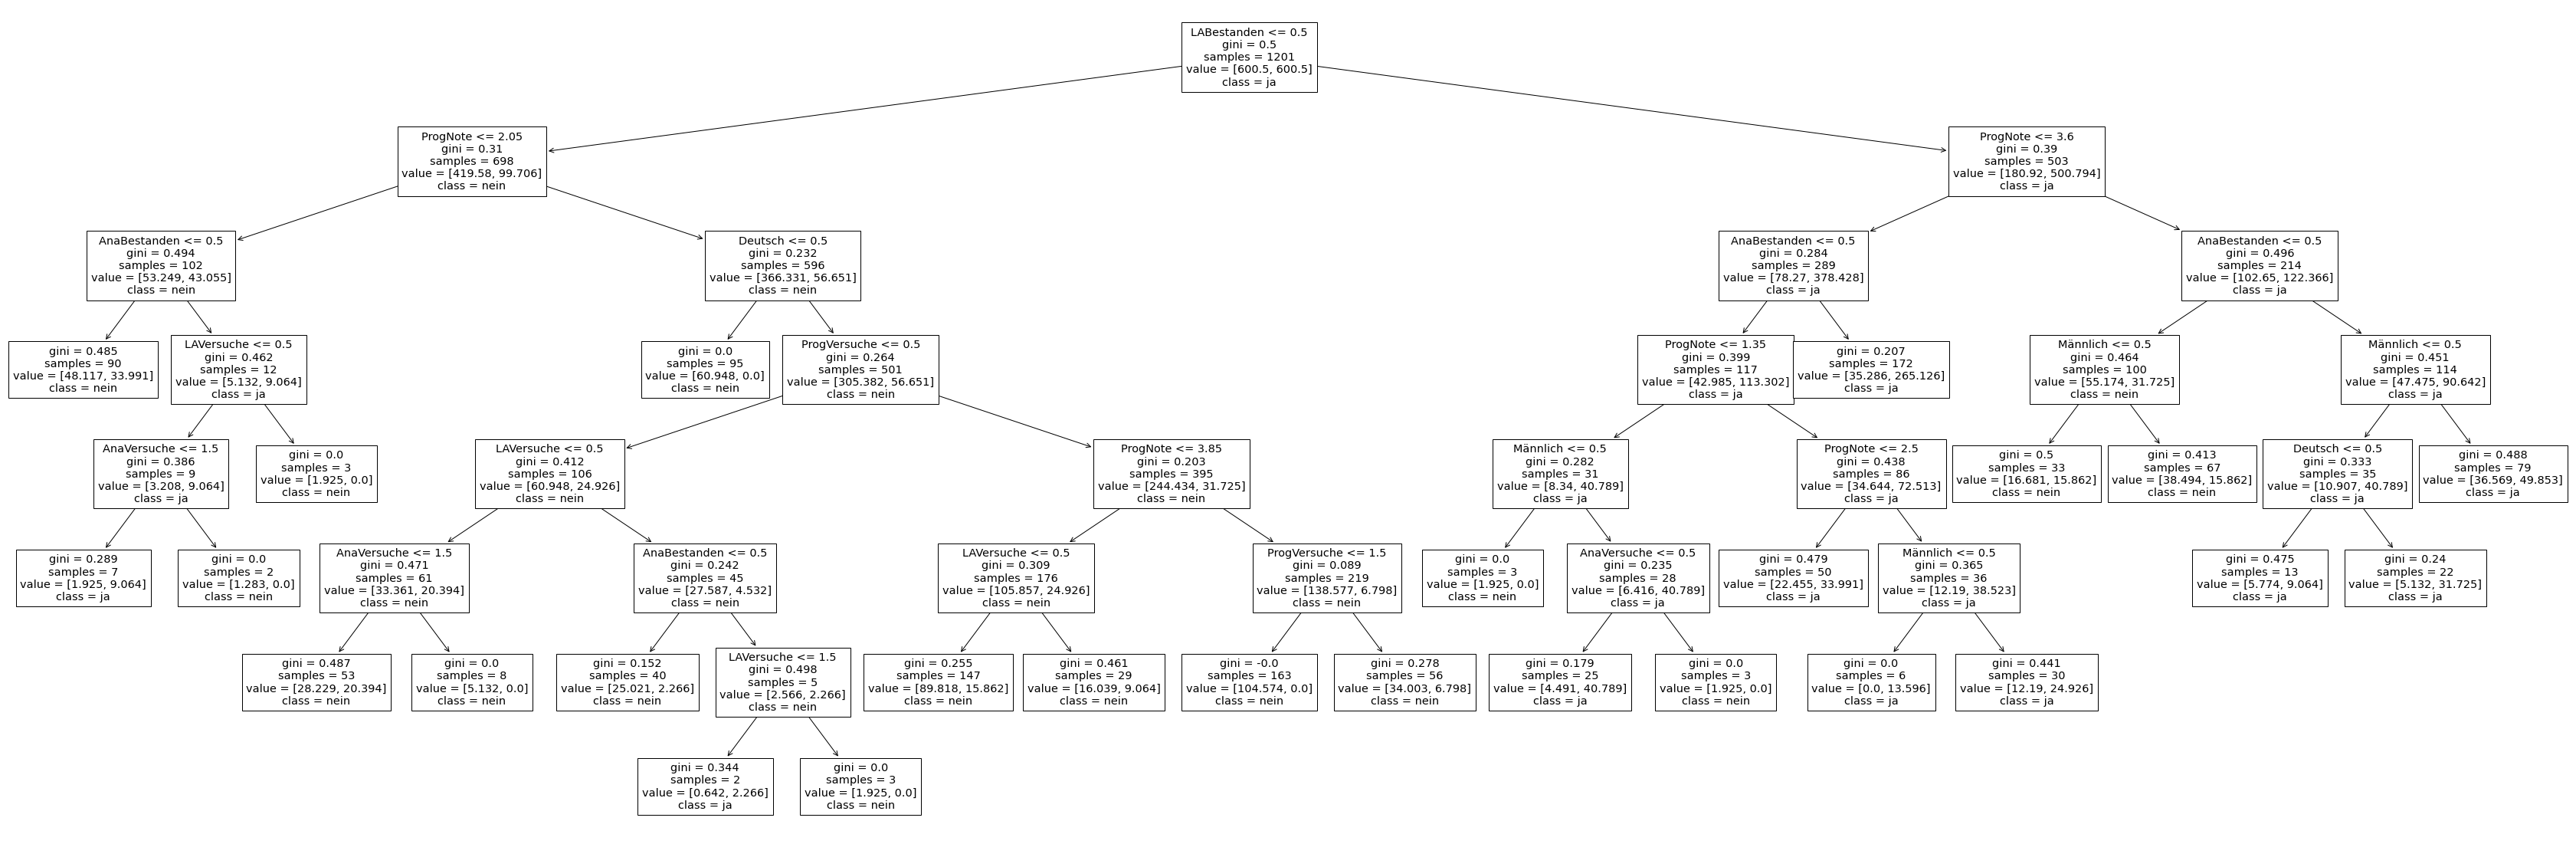

In [17]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

(Right click image -> open in new tab to get a zoomable version.)

Most discriminatory feature is LA1. Students who do not pass it will not have enough credits at end of fourth term.
Makes sense as students who do not pass it might not reach end of third term anyway.

## Explainable model: reduce complexity

In [18]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.0010947 , 0.00110002, 0.00127637, 0.00129698,
        0.00135684, 0.0013601 , 0.00144503, 0.00150363, 0.00190115,
        0.00203886, 0.00237176, 0.00242477, 0.00274132, 0.00425101,
        0.00753168, 0.01280908, 0.0203622 , 0.14451748]),
 'impurities': array([0.27670551, 0.27889491, 0.27999493, 0.28382405, 0.28512103,
        0.28647787, 0.28783797, 0.29072803, 0.29223165, 0.29413281,
        0.30024939, 0.30262115, 0.30504592, 0.31052856, 0.31477957,
        0.32231124, 0.33512032, 0.35548252, 0.5       ])}

Text(0, 0.5, 'Balanced Accuracy scores')

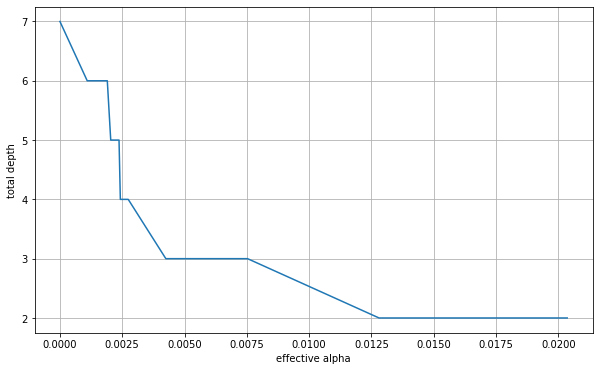

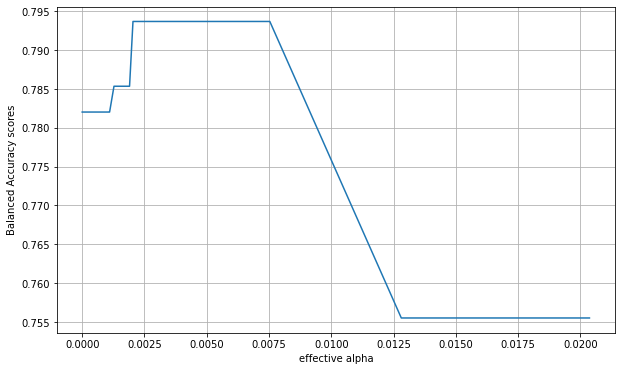

In [19]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")


# Trainset
Balanced accuracy: 0.7858651830349943
Area under curve: 0.7858651830349943
Confusion Matrix (tn, fp, fn, tp):
[[740 196]
 [ 58 207]]
# Testset
Balanced accuracy: 0.7936877076411961
Area under curve: 0.793687707641196
Confusion Matrix (tn, fp, fn, tp):
[[237  64]
 [ 20  80]]


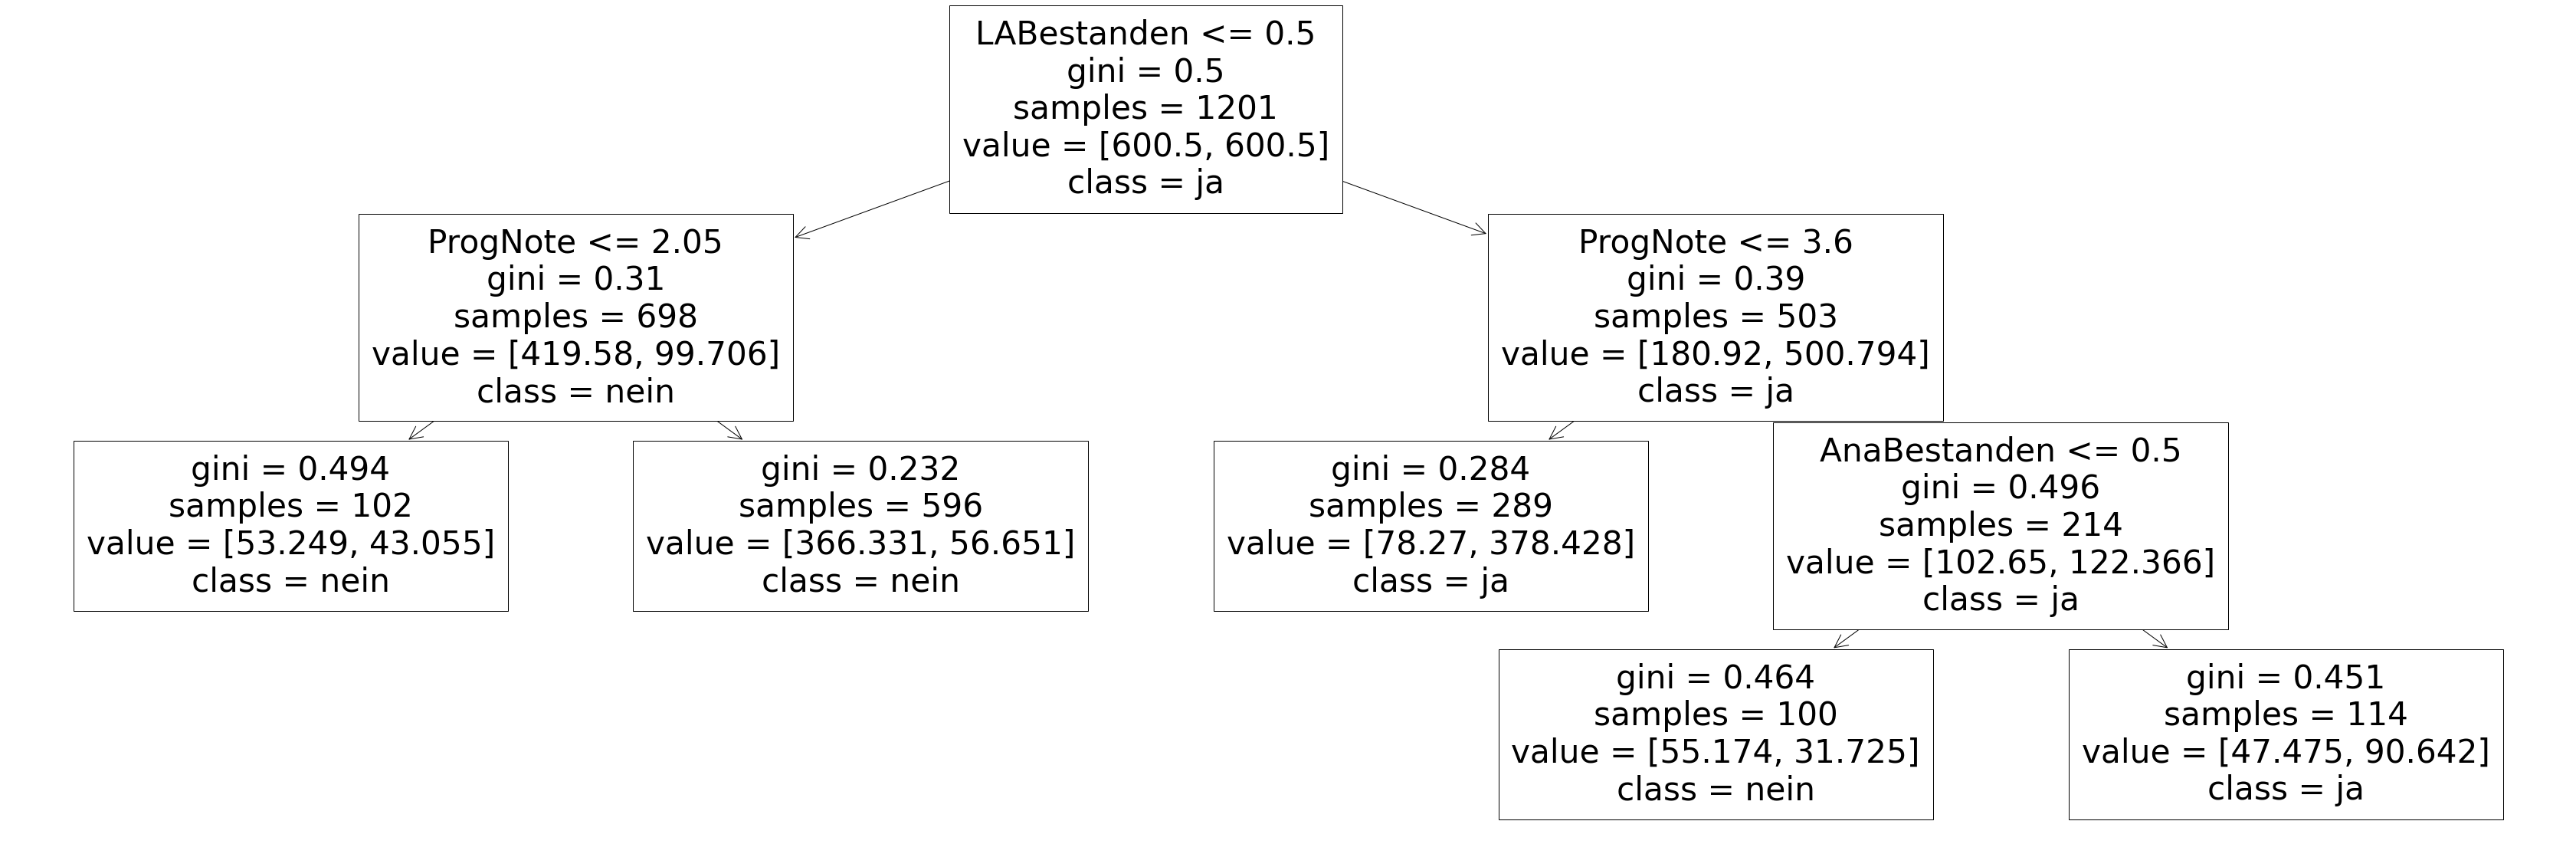

In [32]:
selected_ccp = 0.0074
# selected_ccp = 0.00733871

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()


## Assess Fairness of Classifier

In [33]:
from rapp.fairness import clf_group_fairness
from rapp.fairness import clf_predictive_equality
from rapp.fairness import clf_equality_of_opportunity

In [34]:
fairness = clf_group_fairness(clf, X_test, ["Männlich", "Deutsch"])

print("Statistical Parity, Sex:", fairness["Männlich"]["disparity"])
print("Statistical Parity, Race:", fairness["Deutsch"]["disparity"])

test = pd.concat([X_test, y_test], axis=1)
fairness = clf_predictive_equality(clf, test, "FourthTermCP", ["Männlich", "Deutsch"])

print("Predictive Equality, Sex:", fairness["Männlich"]["disparity"])
print("Predictive Equality, Race:", fairness["Deutsch"]["disparity"])

fairness = clf_equality_of_opportunity(clf, test, "FourthTermCP", ["Männlich", "Deutsch"])

print("Equality of Opportunity, Sex:", fairness["Männlich"]["disparity"])
print("Equality of Opportunity, Race:", fairness["Deutsch"]["disparity"])


Statistical Parity, Sex: 0.007419183889772085
Statistical Parity, Race: 0.06454451345755696
Predictive Equality, Sex: 0.05895691609977324
Predictive Equality, Race: 0.031007751937984496
Equality of Opportunity, Sex: 0.05198180636777128
Equality of Opportunity, Race: -0.12378426171529622


We see that our model exhibits discrimination, most notably against race.
Equality of opportunity says
$$P(\hat{Y}=1\mid Y=1, Z=0) = P(\hat{Y}=1\mid Y=0, Z=0)$$
for the prediction $\hat{Y}$, ground truth $Y$, and protected attribute $Z$.
We see clearly, that a disparity of -0.12 favours more strongly to predict the unfavourable outcome to non-German students.

However, the model we are using does not make use of any discriminatory attributes but the exam grade(s).

## Finding the unfair differences

In [35]:
X_train_priv = X_train[X_train["Deutsch"] == 1]
y_train_priv = y_train[X_train["Deutsch"] == 1]
X_test_priv = X_test[X_test["Deutsch"] == 1]
y_test_priv = y_test[X_test["Deutsch"] == 1]

X_train_unpriv = X_train[X_train["Deutsch"] == 0]
y_train_unpriv = y_train[X_train["Deutsch"] == 0]
X_test_unpriv = X_test[X_test["Deutsch"] == 0]
y_test_unpriv = y_test[X_test["Deutsch"] == 0]

In [46]:
clf_priv = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)
clf_priv.fit(X_train_priv, y_train_priv)

clf_unpriv = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)
clf_unpriv.fit(X_train_unpriv, y_train_unpriv)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

### Priviliged Group

In [47]:
eval_model(clf_priv, X_train_priv, y_train_priv, X_test_priv, y_test_priv)

# Trainset
Balanced accuracy: 0.8049769267261828
Area under curve: 0.8049769267261827
Confusion Matrix (tn, fp, fn, tp):
[[586 200]
 [ 32 204]]
# Testset
Balanced accuracy: 0.7723202352312216
Area under curve: 0.7723202352312215
Confusion Matrix (tn, fp, fn, tp):
[[185  73]
 [ 15  72]]


Text(0, 0.5, 'Balanced Accuracy scores')

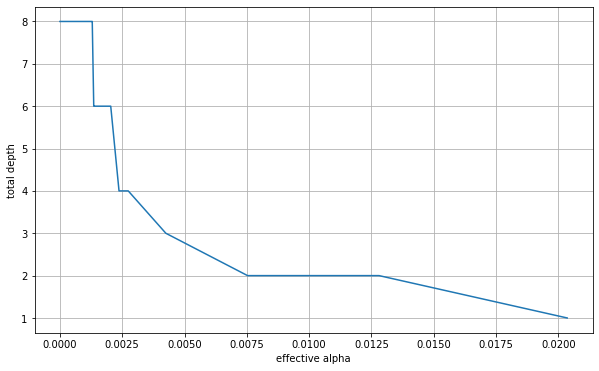

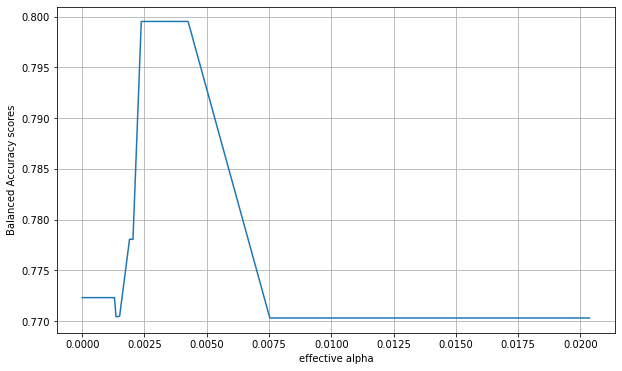

In [48]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train_priv, y_train_priv)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test_priv, clf.predict(X_test_priv)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")


# Trainset
Balanced accuracy: 0.779785008841161
Area under curve: 0.7797850088411609
Confusion Matrix (tn, fp, fn, tp):
[[623 163]
 [ 55 181]]
# Testset
Balanced accuracy: 0.7995188452285484
Area under curve: 0.7995188452285487
Confusion Matrix (tn, fp, fn, tp):
[[202  56]
 [ 16  71]]


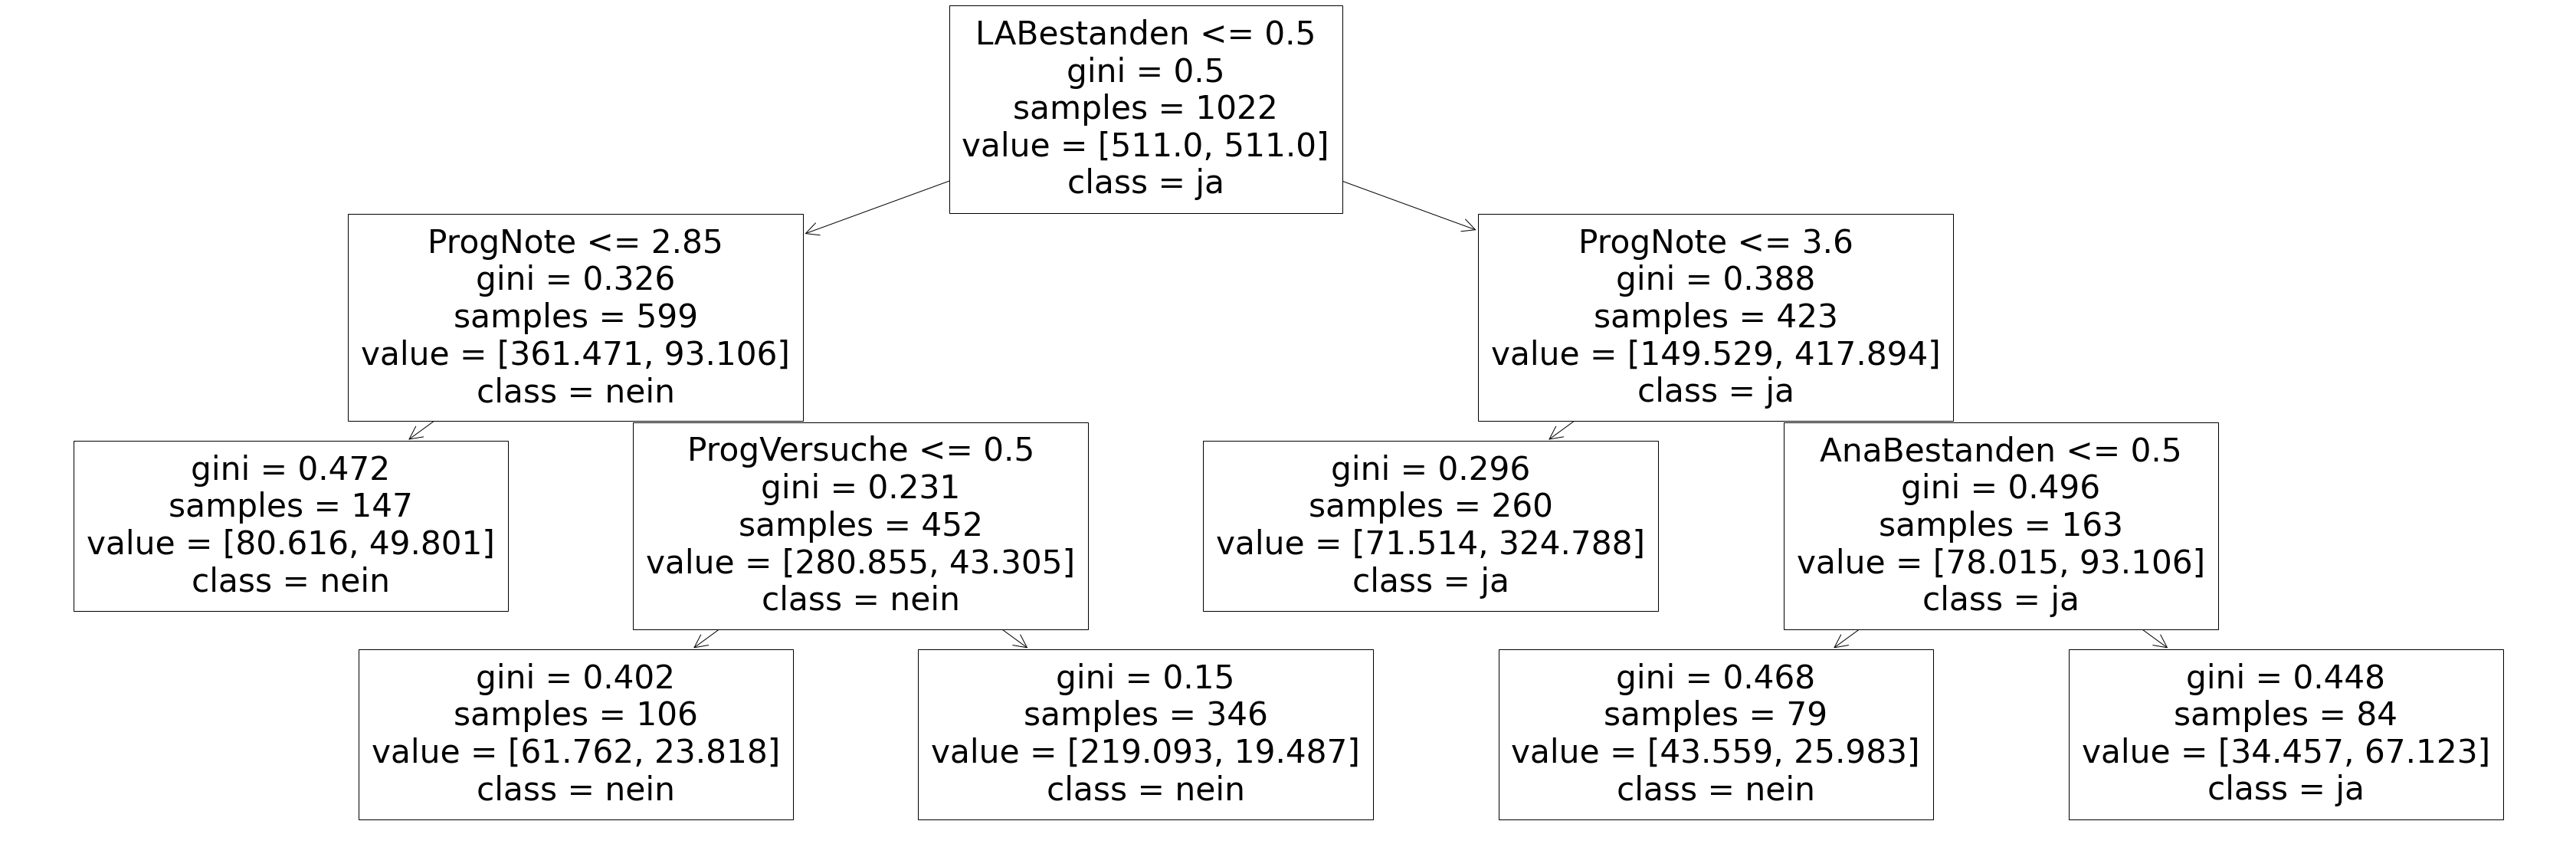

In [49]:
selected_ccp = 0.004
# selected_ccp = 0.00733871

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train_priv, y_train_priv)

eval_model(clf, X_train_priv, y_train_priv, X_test_priv, y_test_priv)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

clf_priv = clf

### Unpriviliged

In [50]:
eval_model(clf_unpriv, X_train_unpriv, y_train_unpriv, X_test_unpriv, y_test_unpriv)

# Trainset
Balanced accuracy: 0.8960919540229886
Area under curve: 0.8960919540229886
Confusion Matrix (tn, fp, fn, tp):
[[124  26]
 [  1  28]]
# Testset
Balanced accuracy: 0.7647584973166368
Area under curve: 0.7647584973166368
Confusion Matrix (tn, fp, fn, tp):
[[36  7]
 [ 4  9]]


Text(0, 0.5, 'Balanced Accuracy scores')

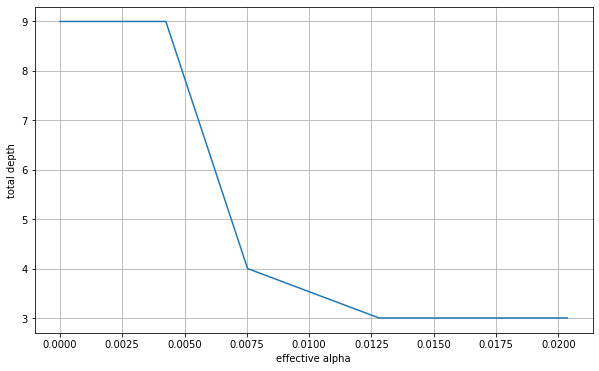

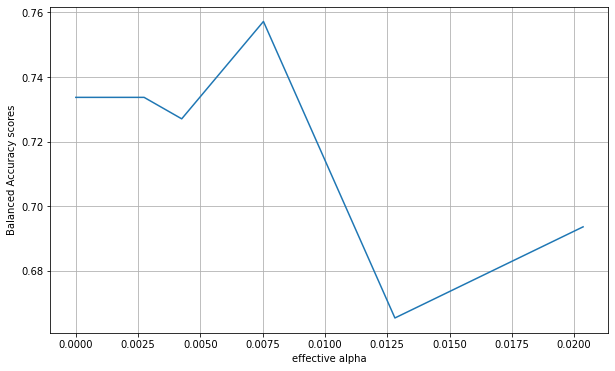

In [51]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train_unpriv, y_train_unpriv)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")



# Trainset
Balanced accuracy: 0.7744900016126431
Area under curve: 0.7744900016126431
Confusion Matrix (tn, fp, fn, tp):
[[641 295]
 [ 36 229]]
# Testset
Balanced accuracy: 0.7571760797342193
Area under curve: 0.7571760797342192
Confusion Matrix (tn, fp, fn, tp):
[[209  92]
 [ 18  82]]


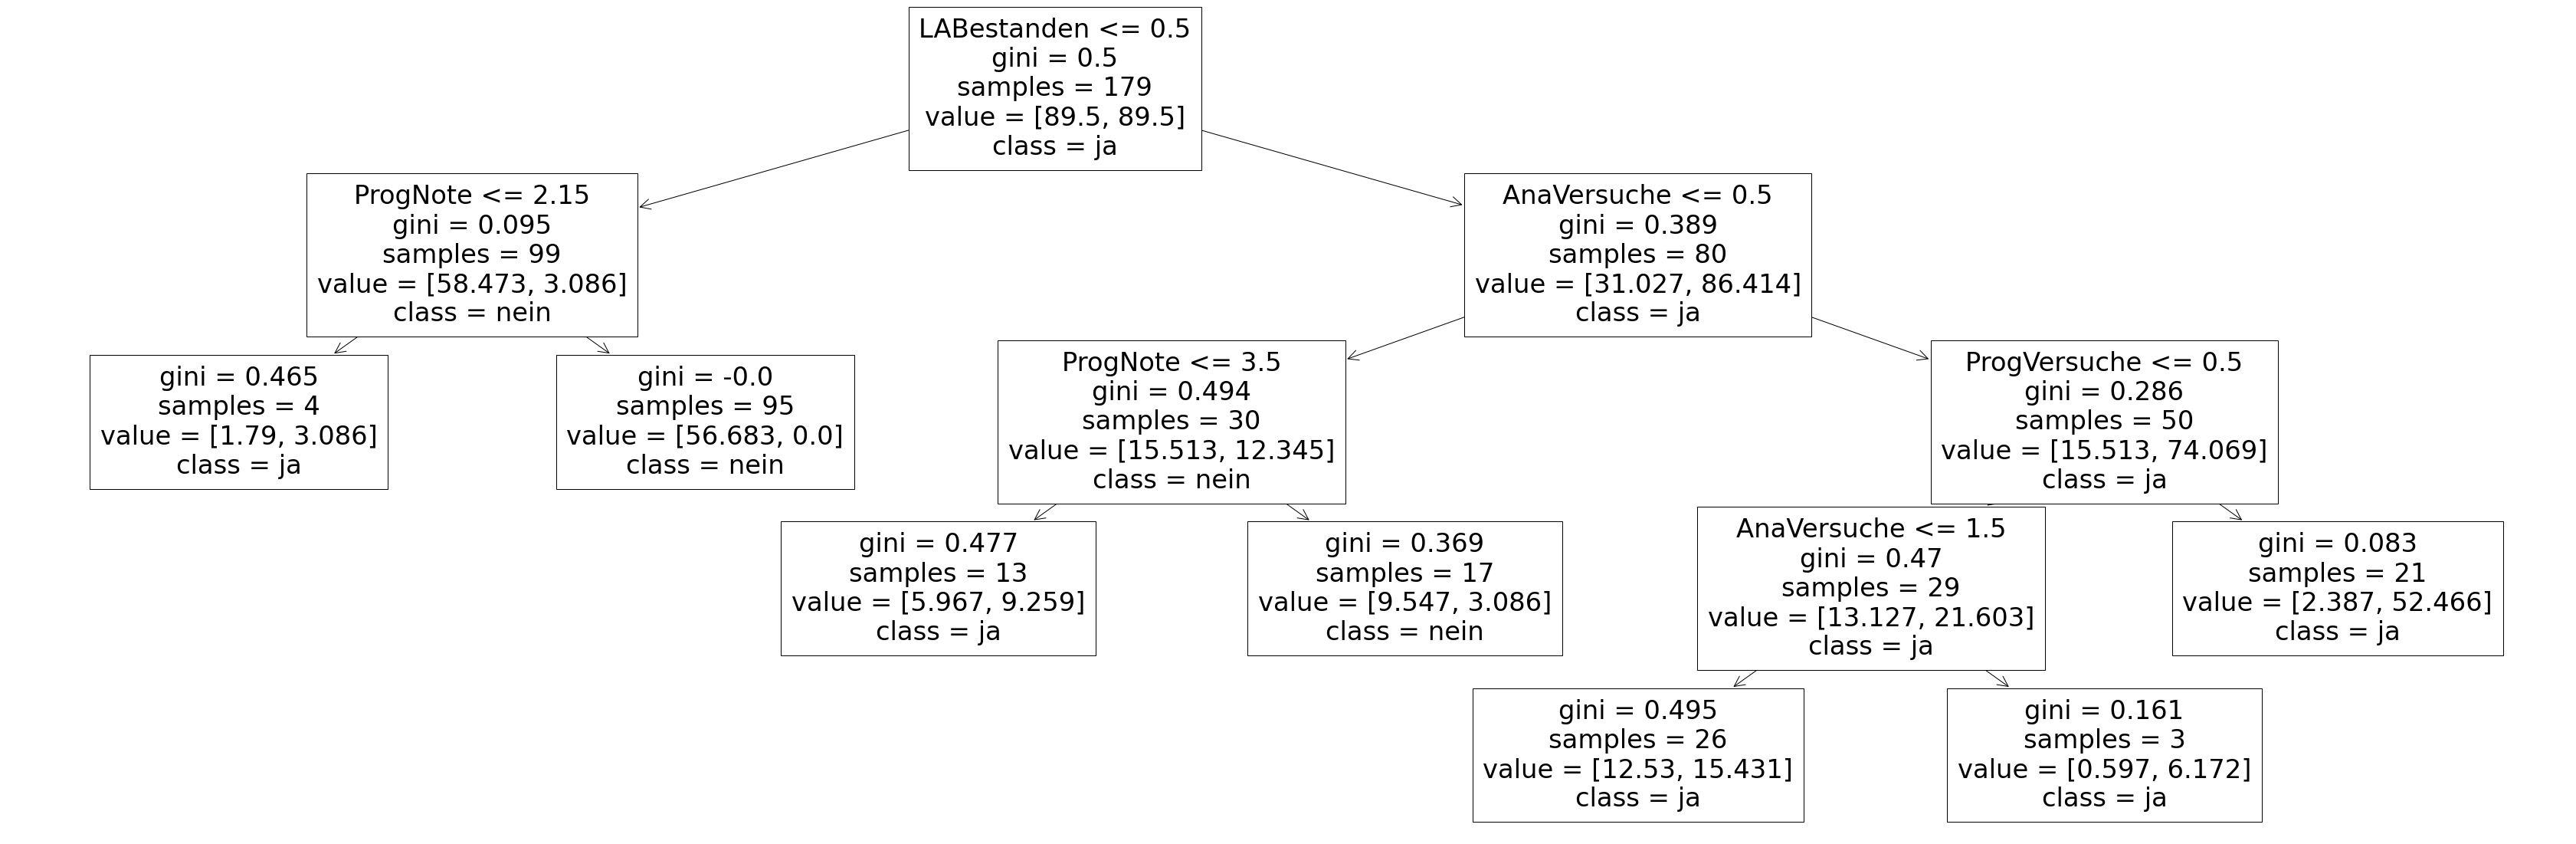

In [52]:
for selected_ccp in [0.0075]:
    clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                                ccp_alpha=selected_ccp)
    clf.fit(X_train_unpriv, y_train_unpriv)

    eval_model(clf)
    plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
    plt.show()

    clf_unpriv = clf

### Differences

We see differences in mostly the right part of the decision tree. 
* For German students' prediction it seems necessary to succeed in Analysis as well as in Linear Algebra.
* For foreign students it is only important that they attempted Analysis in their first semester to predict study success. Those students where rejected by the initial model though, leading to the discrimination regarding Equality of Opportunity measure

While we found a root cause in the predictive model for the unfairness, we clearly see that this stems from a non-WAE worldview where, and this is already interpretational,
foreign students behave differently during their course of study (assumption).

### Only LA as predictive attribute

In [55]:
class LADummy():
    def predict(self, df):
        return df["LABestanden"]

clf_la = LADummy()

In [57]:
print("## Priviliged LA-only classifier")
eval_model(clf_la, X_train_priv, y_train_priv, X_test_priv, y_test_priv)
print("## Unpriviliged LA-only classifier")
eval_model(clf_la, X_train_unpriv, y_train_unpriv, X_test_unpriv, y_test_unpriv)

## Priviliged LA-only classifier
# Trainset
Balanced accuracy: 0.7625878725147712
Area under curve: 0.7625878725147712
Confusion Matrix (tn, fp, fn, tp):
[[556 230]
 [ 43 193]]
# Testset
Balanced accuracy: 0.770315423683507
Area under curve: 0.7703154236835071
Confusion Matrix (tn, fp, fn, tp):
[[181  77]
 [ 14  73]]
## Unpriviliged LA-only classifier
# Trainset
Balanced accuracy: 0.8094252873563219
Area under curve: 0.8094252873563219
Confusion Matrix (tn, fp, fn, tp):
[[98 52]
 [ 1 28]]
# Testset
Balanced accuracy: 0.6601073345259392
Area under curve: 0.6601073345259392
Confusion Matrix (tn, fp, fn, tp):
[[27 16]
 [ 4  9]]


In [58]:
clf = clf_la
fairness = clf_group_fairness(clf, X_test, ["Männlich", "Deutsch"])

print("Statistical Parity, Sex:", fairness["Männlich"]["disparity"])
print("Statistical Parity, Race:", fairness["Deutsch"]["disparity"])

test = pd.concat([X_test, y_test], axis=1)
fairness = clf_predictive_equality(clf, test, "FourthTermCP", ["Männlich", "Deutsch"])

print("Predictive Equality, Sex:", fairness["Männlich"]["disparity"])
print("Predictive Equality, Race:", fairness["Deutsch"]["disparity"])

fairness = clf_equality_of_opportunity(clf, test, "FourthTermCP", ["Männlich", "Deutsch"])

print("Equality of Opportunity, Sex:", fairness["Männlich"]["disparity"])
print("Equality of Opportunity, Race:", fairness["Deutsch"]["disparity"])



Statistical Parity, Sex: -0.07657657657657657
Statistical Parity, Race: -0.01164596273291929
Predictive Equality, Sex: -0.04535147392290251
Predictive Equality, Race: -0.0736434108527132
Equality of Opportunity, Sex: 0.09226770630279402
Equality of Opportunity, Race: -0.14677276746242265


In [73]:
test_unpriv = pd.concat([X_test_unpriv, y_test_unpriv], axis=1)

test_unpriv[(test_unpriv["LABestanden"] == 0) & (test_unpriv["FourthTermCP"] == 1)]

,Deutsch,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AnaBestanden,AnaVersuche,Männlich,Weiblich,Divers,FourthTermCP
941,0,0,0,1,1,3.30,1,1,1,0,0,1
732,0,0,0,1,1,1.65,0,0,1,0,0,1
1037,0,0,0,1,1,2.30,0,0,1,0,0,1
1135,0,0,0,0,0,5.00,1,1,1,0,0,1


In [74]:
test_priv = pd.concat([X_test_priv, y_test_priv], axis=1)
test_priv[(test_priv["LABestanden"] == 0) & (test_priv["FourthTermCP"] == 1)]

,Deutsch,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AnaBestanden,AnaVersuche,Männlich,Weiblich,Divers,FourthTermCP
1054,1,0,0,0,0,5.0,1,1,1,0,0,1
10,1,0,0,1,1,2.7,1,1,1,0,0,1
421,1,0,0,0,0,5.0,1,1,1,0,0,1
274,1,0,2,1,1,2.3,0,2,1,0,0,1
955,1,0,0,0,0,5.0,1,1,1,0,0,1
885,1,0,0,1,1,3.0,1,1,1,0,0,1
269,1,0,1,1,1,4.0,1,2,0,1,0,1
1149,1,0,0,0,0,5.0,0,1,0,1,0,1
14,1,0,0,1,1,2.7,0,0,1,0,0,1
1307,1,0,0,1,1,1.3,0,0,1,0,0,1


In [82]:
eoo_unpriv = len(test_unpriv[(test_unpriv["LABestanden"] == 0) & (test_unpriv["FourthTermCP"] == 1)]) / len(test_unpriv[test_unpriv["FourthTermCP"] == 1])
eoo_priv = len(test_priv[(test_priv["LABestanden"] == 0) & (test_priv["FourthTermCP"] == 1)]) / len(test_priv[test_priv["FourthTermCP"] == 1])


print(f"Priv:   Y=1: {len(test_priv[test_priv['FourthTermCP'] == 1])}, Ŷ=1 & Y=1: {len(test_priv[(test_priv['LABestanden'] == 0) & (test_priv['FourthTermCP'] == 1)])} ({eoo_priv:.3f}%)")
print(f"Unpriv: Y=1: {len(test_unpriv[test_unpriv['FourthTermCP'] == 1])}, Ŷ=1 & Y=1: {len(test_unpriv[(test_unpriv['LABestanden'] == 0) & (test_unpriv['FourthTermCP'] == 1)])} ({eoo_unpriv:.3f}%)")
print(f"Disparity: {eoo_priv - eoo_unpriv}")

Priv:   Y=1: 87, Ŷ=1 & Y=1: 14 (0.161%)
Unpriv: Y=1: 13, Ŷ=1 & Y=1: 4 (0.308%)
Disparity: -0.14677276746242265


After investigating further, the main problem seems to be too low of a sampling size.